In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

## Recall:
Yesterday, we developed a simple differentiable forward model and demonstrated a simple fitting of this forward model: namely, using 100 timesteps along a given trajectory, we can use our physics model and gradient descent to fit the initial position, velocity, and acceleration.

As a reminder: our forward model is one function

In [2]:
def position(t, a, x0, v0):
    return x0 + v0*t + 0.5*a*t**2

which takes in parameters and (measurement) time steps

In [3]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_target = torch.tensor([0, -9.8])[None, :]

#Initial velocity for fun (m / s)
v0_target = torch.tensor([5, 10])[None, :]

#Start at (0,10) [m]
x0_target = torch.tensor([0,10])[None, :]

#Data taken at 100 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[:, None]

In [4]:
trajectory_target = position(time_steps, a_target, x0_target, v0_target)

## Today: Who needs differentiable simulators, anyway?

Rather than doing a parameter fitting with a differentiable forward model, we can also frame this fitting as a data-driven regression problem: namely given known trajectories $X$, corresponding parameters $\theta$, learn a model $f$ such that:

\begin{equation}
f(X) = \theta
\end{equation}

This is a fairly straightforward supervised learning problem -- let's try this out with a simple multi-layer perceptron (MLP). With PyTorch, we can make this as follows:

In [5]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define layers -- we include 1 hidden layer for fun
        self.layers = nn.Sequential(
                          nn.Flatten(),
                          nn.Linear(200, 50),
                          nn.ReLU(),
                          nn.Linear(50, 6)
                        )


    def forward(self, x):
        out = self.layers(x)
        out = out.reshape((-1, 3, 2))
        return out

We can then set up inputs and targets with appropriate dimensions. Let's do a single point to show that it works, but we'll add a new array dimension to allow for multiple trajectories (the "batch dimension").

In [6]:
inputs = trajectory_target[None, :, :]
targets = torch.stack([a_target, x0_target, v0_target]).squeeze()[None, ...]

The training loop should look pretty familiar from yesterday:

In [7]:
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

# Run the training loop
for epoch in tqdm(range(1000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp(inputs)

    # Compute loss
    loss = loss_fn(outputs, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1933.13it/s]


and it converges, as we expect

In [8]:
outputs, targets

(tensor([[[-5.6624e-07, -9.8000e+00],
          [-1.7136e-07,  1.0000e+01],
          [ 5.0000e+00,  1.0000e+01]]], grad_fn=<ReshapeAliasBackward0>),
 tensor([[[ 0.0000, -9.8000],
          [ 0.0000, 10.0000],
          [ 5.0000, 10.0000]]]))

We can try a not as silly example with some set of trajectories to learn some meaningful parameter estimation -- let's just do a range of different accelerations for simplicity, and include a validation set just to check

v0 and x0 is the same for everything, we use torch.tile to repeat it a relevant number of times

In [9]:
train_size = 50
valid_size = 50

#Initial velocity for fun (m / s)
v0s = torch.tile(torch.tensor([5., 10.])[None, :], (train_size+valid_size, 1, 1))

#Start at (0,10) [m]
x0s = torch.tile(torch.tensor([0.,10.])[None, :], (train_size+valid_size, 1, 1))

#Data taken at 100 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[None, :, None]

Take some range of y-accelerations

In [10]:
acc_range = torch.linspace(-12, 12, train_size+valid_size)

and then construct training and validation sets (seeding for reproducibility)

In [11]:
torch.manual_seed(0)
rand_idxs = torch.randperm(train_size+valid_size)
train_idxs = rand_idxs[:train_size]
valid_idxs = rand_idxs[valid_size:]

In [12]:
accs_train = torch.zeros(size=(train_size, 1, 2))
accs_train[:, :, 1] = acc_range[train_idxs][:, None]

v0s_train =  v0s[train_idxs]
x0s_train = x0s[train_idxs]

trajectories_target_train = position(time_steps, accs_train, x0s_train, v0s_train)

In [13]:
accs_valid = torch.zeros(size=(valid_size, 1, 2))
accs_valid[:, :, 1] = acc_range[valid_idxs][:, None]

v0s_valid =  v0s[valid_idxs]
x0s_valid = x0s[valid_idxs]

trajectories_target_valid = position(time_steps, accs_valid, x0s_valid, v0s_valid)

Package into appropriate shape

In [14]:
inputs = trajectories_target_train
targets = torch.cat((accs_train, x0s_train, v0s_train), dim=1)

inputs_val = trajectories_target_valid
targets_val = torch.cat((accs_valid, x0s_valid, v0s_valid), dim=1)

And then train real quick

In [15]:
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)

losses = []
losses_val = []
# Run the training loop
for epoch in tqdm(range(20000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp(inputs)

    # Compute loss
    loss = loss_fn(outputs, targets)
    
    with torch.no_grad():
        out_valid = mlp(inputs_val)
        loss_valid = loss_fn(out_valid, targets_val)
        losses_val.append(loss_valid)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    
    losses.append(loss.item())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1564.32it/s]


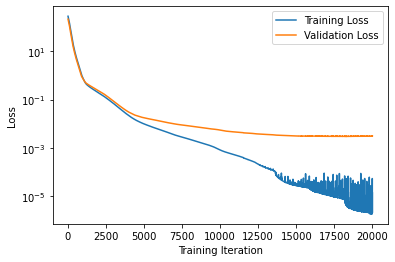

In [16]:
plt.plot(losses, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.yscale('log')
plt.legend()
plt.xlabel('Training Iteration')
plt.ylabel('Loss')
plt.show()

Let's test the MLP prediction by a) sampling more finely and b) expanding the range of acceleration values considered

In [17]:
n_test = 300
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
accs_test = torch.zeros(size=(n_test, 1, 2))
accs_test[:, :, 1] = torch.linspace(-13, 13, n_test)[:, None]

#Initial velocity for fun (m / s)
v0s = torch.tile(torch.tensor([5, 10])[None, :], (n_test, 1, 1))

#Start at (0,10) [m]
x0s = torch.tile(torch.tensor([0,10])[None, :], (n_test, 1, 1))

#Data taken at n_test known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[None, :, None]

trajectories_test = position(time_steps, accs_test, x0s, v0s)

In [18]:
pred = mlp(trajectories_test).detach()
ax_test = pred[:, 0, 0]
ay_test = pred[:, 0, 1]

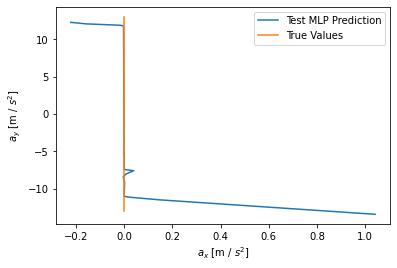

In [19]:
plt.plot(ax_test, ay_test, label='Test MLP Prediction')
plt.plot(accs_test[:, 0, 0], accs_test[:, 0, 1], label='True Values')
plt.xlabel('$a_{x}$ [m / $s^2$]')
plt.ylabel('$a_{y}$ [m / $s^2$]')
plt.legend()
#plt.xlim(-0.1, 0.1)
plt.show()

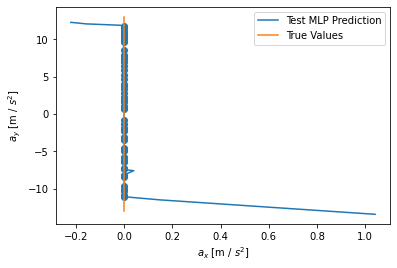

In [20]:
plt.plot(ax_test, ay_test, label='Test MLP Prediction')
plt.plot(accs_test[:, 0, 0], accs_test[:, 0, 1], label='True Values')
plt.scatter(accs_train[:, 0, 0], accs_train[:, 0, 1])
plt.xlabel('$a_{x}$ [m / $s^2$]')
plt.ylabel('$a_{y}$ [m / $s^2$]')
plt.legend()
#plt.xlim(-0.1, 0.1)
plt.show()

The MLP predictions for acceleration are very close to true values within the training range, but diverge as we go away from the training points -- we can, of course, make better models, but this emphasizes a point -- the MLP is fitting to training data, but has no explicit knowledge of the physics. 

But -- we've learned a (very simple) data-driven model for parameter estimation

## Why is this useful? 

Yesterday, we showed that given (1) a physics model (our differentiable forward model) and (2) a target trajectory, we could use gradient descent to learn the parameters of the target. 

In symbols, we have a simulator $\Phi$ that maps from parameters $\theta$ to trajectories $X$, or:

\begin{equation}
\Phi(\theta) = X.
\end{equation}

We can solve for the parameters of an arbitrary trajectory by _explicitly_ iterating on input parameters: namely comparing the output trajectory from some initial parameter guess and using backpropagation/gradient descent to update this parameter guess.


Today, we have demonstrated that with no physics model, but with a set of trajectories and parameters, we can do a supervised training of a neural network to create a map from trajectories to parameters, namely, calling this map $f$, we learn

\begin{equation}
f(X) = \theta.
\end{equation}




This supervised training is nice, and it works, but what if we only have the simulator and some data? Can we still learn f? It turns out, yes! We can do so with what we'll call a cycle-consistent loss, namely, if we chain together f and $\Phi$, we get a mapping:

\begin{equation}
\Phi\circ f: X \rightarrow \theta \rightarrow X'.
\end{equation}

In words, if we pass a set of trajectories through both $f$ and $\Phi$, we get a new set of trajectories. Since $\Phi$ is differentiable, we can backpropagate to update the parameters of $f$. In particular, if we define the loss such that $\Phi\circ f$ tries to reconstruct the input trajectories ($\Phi\circ f(X) = X$), we should _implicitly_ learn a mapping from $X$ to $\theta$. That was a lot of words, so let's try it!

### Exercise:

Write a loss function that takes in  

Same training set as before:

In [143]:
train_size = 50
valid_size = 50

#Initial velocity for fun (m / s)
v0s = torch.tile(torch.tensor([5., 10.])[None, :], (train_size+valid_size, 1, 1))

#Start at (0,10) [m]
x0s = torch.tile(torch.tensor([0.,10.])[None, :], (train_size+valid_size, 1, 1))

#Data taken at 100 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[None, :, None]

Take some range of y-accelerations

In [144]:
acc_range = torch.linspace(-12, 12, train_size+valid_size)

and then construct training and validation sets (seeding for reproducibility)

In [145]:
torch.manual_seed(0)
rand_idxs = torch.randperm(train_size+valid_size)
train_idxs = rand_idxs[:train_size]
valid_idxs = rand_idxs[valid_size:]

In [146]:
accs_train = torch.zeros(size=(train_size, 1, 2))
accs_train[:, :, 1] = acc_range[train_idxs][:, None]

v0s_train =  v0s[train_idxs]
x0s_train = x0s[train_idxs]

trajectories_target_train = position(time_steps, accs_train, x0s_train, v0s_train)

In [147]:
accs_valid = torch.zeros(size=(valid_size, 1, 2))
accs_valid[:, :, 1] = acc_range[valid_idxs][:, None]

v0s_valid =  v0s[valid_idxs]
x0s_valid = x0s[valid_idxs]

trajectories_target_valid = position(time_steps, accs_valid, x0s_valid, v0s_valid)

Package into appropriate shape

In [148]:
inputs = trajectories_target_train
targets = torch.cat((accs_train, x0s_train, v0s_train), dim=1)

inputs_val = trajectories_target_valid
targets_val = torch.cat((accs_valid, x0s_valid, v0s_valid), dim=1)

Now we run a training

In [18]:
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)

losses = []
losses_cc = []
losses_val = []
# Run the training loop
for epoch in tqdm(range(20000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp(inputs)
    
    #Forward model
    outputs_reshape = outputs.reshape((-1, 3, 2))
    outputs_reshape = torch.unsqueeze(outputs_reshape, 1)
    a = outputs_reshape[:, :, 0]
    v0 = outputs_reshape[:, :, 1]
    x0 = outputs_reshape[:, :, 2]
    
    traj = position(time_steps, a, v0, x0)
    
    # Compute loss
    loss_cc = loss_fn(traj, inputs)
    
    loss = loss_cc
    
    with torch.no_grad():
        out_valid = mlp(inputs_val)
        loss_valid = loss_fn(out_valid, targets_val)
        losses_val.append(loss_valid)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    
    losses.append(loss.item())
    losses_cc.append(loss_cc.item())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1205.13it/s]


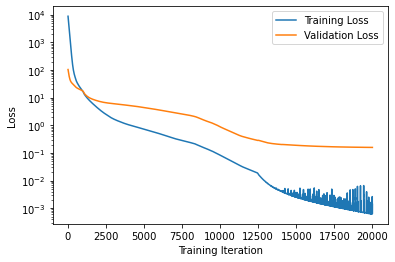

In [19]:
plt.plot(losses, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.yscale('log')
plt.legend()
plt.xlabel('Training Iteration')
plt.ylabel('Loss')
plt.show()

Let's test the MLP prediction by a) sampling more finely and b) expanding the range of acceleration values considered

In [20]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
accs_test = torch.zeros(size=(100, 1, 2))
accs_test[:, :, 1] = torch.linspace(-14, 14, 100)[:, None]

#Initial velocity for fun (m / s)
v0s = torch.tile(torch.tensor([5, 10])[None, :], (100, 1, 1))

#Start at (0,10) [m]
x0s = torch.tile(torch.tensor([0,10])[None, :], (100, 1, 1))

#Data taken at 100 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[None, :, None]

trajectories_test = position(time_steps, accs_test, x0s, v0s)

In [21]:
pred = mlp(trajectories_test).detach()
ax_test = pred[:, 0, 0]
ay_test = pred[:, 0, 1]

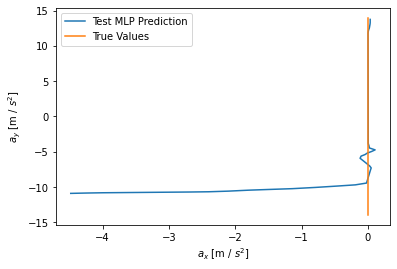

In [22]:
plt.plot(ax_test, ay_test, label='Test MLP Prediction')
plt.plot(accs_test[:, 0, 0], accs_test[:, 0, 1], label='True Values')
plt.xlabel('$a_{x}$ [m / $s^2$]')
plt.ylabel('$a_{y}$ [m / $s^2$]')
plt.legend()
#plt.xlim(-0.1, 0.1)
plt.show()

It works! Note that such a loss can also be added to the fully supervised setting as a _regularization term_.

## Single trajectories and autoencoders

This idea of implicit variables and "trying to reconstruct the inputs" may be ringing some bells -- the loss that we've defined above is effectively an _autoencoder_, where $f$ _encodes_ trajectories into a latent parameter space, and $\Phi$ _decodes_ these latent parameters back into trajectory space. 

The fun thing with this tutorial is that only the encoder is learnable -- the decoder is fixed, and given by the forward model. Crucially, however, our decoder is differentiable, otherwise we wouldn't be able to learn the encoder in the same way.

Let's write this autoencoder structure explicitly -- some lines might look familiar...

In [23]:
class MLP_autoencoder(nn.Module):
    '''
    Multilayer Perceptron.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                          nn.Flatten(),
                          nn.Linear(200, 50),
                          nn.ReLU(),
                          nn.Linear(50, 6)
                        )
        self.timesteps = torch.linspace(0, 5, 100)[:, None]

    def encode(self, x):
        '''Forward pass'''
        out = self.layers(x)
        out = out.reshape((-1, 3, 2))
        return out
    
    def decode(self, x):
        x = torch.unsqueeze(x, 1)
        a = x[:, :, 0]
        v0 = x[:, :, 1]
        x0 = x[:, :, 2]
        return position(self.timesteps, a, v0, x0)
    
    def forward(self, x):
        enc = self.encode(x)
        dec = self.decode(enc)
        return dec

We've demonstrated what such a structure does in the context of multiple trajectories, but let's focus for now on a single trajectory. Training is much the same as usual:

In [27]:
inputs = trajectory_target[None, :, :]
targets = torch.stack([a_target, x0_target, v0_target]).squeeze()[None, ...]

In [28]:
# Initialize the MLP
mlp_auto = MLP_autoencoder()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_auto.parameters(), lr=1e-4)

# Run the training loop
for epoch in tqdm(range(5000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp_auto(inputs)

    # Compute loss
    loss = loss_fn(outputs, inputs)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1560.89it/s]


Where the input and output trajectories match:

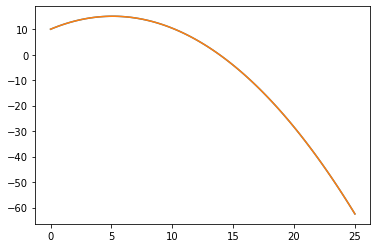

In [29]:
plt.plot(outputs.detach().numpy()[0, :, 0], outputs.detach().numpy()[0, :, 1])
plt.plot(inputs.numpy()[0, :, 0], inputs.numpy()[0, :, 1])
plt.show()

And the outputs of the encoder match the "true" parameters:

In [30]:
mlp_auto.encode(inputs), targets

(tensor([[[ 1.4752e-05, -9.8000e+00],
          [-9.6187e-06,  1.0000e+01],
          [ 5.0000e+00,  1.0000e+01]]], grad_fn=<ReshapeAliasBackward0>),
 tensor([[[ 0.0000, -9.8000],
          [ 0.0000, 10.0000],
          [ 5.0000, 10.0000]]]))

## Noisy inputs and encoding
Now suppose we have some measurement noise, which we'll assume to be Gaussian for simplicity. We can make the same measurement multiple times, which gives us a bit more info:

In [31]:
noisy_target = trajectory_target + torch.normal(torch.zeros((500,)+trajectory_target.shape), 
                                                torch.ones((500,)+trajectory_target.shape)*0.2)

In [32]:
noisy_target.shape

torch.Size([500, 100, 2])

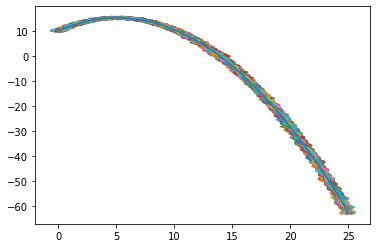

In [33]:
for i in range(len(noisy_target)):
    plt.plot(noisy_target[i, :, 0], noisy_target[i, :, 1])
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1])
plt.show()

We might expect noise on the input to translate into some uncertainty on the fitted trajectory parameters. How do we estimate this? A first naive thing to do is try to learn parameters for each measurement -- we'll do so with our autoencoder setup for now:

In [34]:
inputs = noisy_target.clone()

In [35]:
# Initialize the MLP
mlp_auto = MLP_autoencoder()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_auto.parameters(), lr=1e-4)

losses = []
# Run the training loop
for epoch in tqdm(range(3000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp_auto(inputs)

    # Compute loss
    loss = loss_fn(outputs, inputs)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    
    losses.append(loss.item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 416.15it/s]


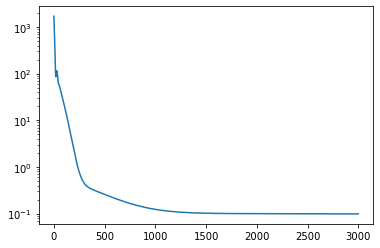

In [36]:
plt.plot(losses)
plt.yscale('log')

Then, let's take a look at our learned parameter values:

In [37]:
params = mlp_auto.encode(inputs).detach()

In [38]:
a_vals = params[:, 0, :]
x0_vals = params[:, 1, :]
v0_vals = params[:, 2, :]

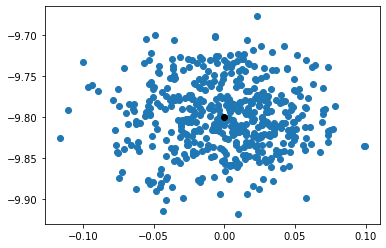

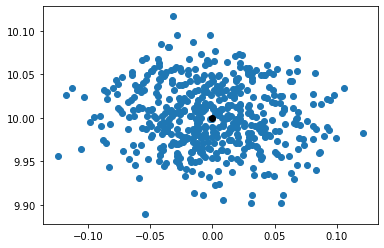

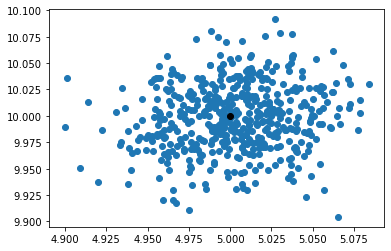

In [62]:
plt.scatter(a_vals[:, 0], a_vals[:, 1])
plt.scatter(a_target[:, 0], a_target[:, 1], c='k')
    
plt.show()


plt.scatter(x0_vals[:, 0], x0_vals[:, 1])
plt.scatter(x0_target[:, 0], x0_target[:, 1], c='k')
    
plt.show()

plt.scatter(v0_vals[:, 0], v0_vals[:, 1])
plt.scatter(v0_target[:, 0], v0_target[:, 1], c='k')
    
plt.show()

The noise on the input results in some _distribution_ of fitted parameter values -- we now have a pipeline to automatically translate a distribution over trajectories into a distribution over parameters! Using this to naively get parameter values + an uncertainty:

In [40]:
from math import sqrt
mean_acc = torch.mean(a_vals, axis=0)

#Std error has factor of 1/sqrt(N)
N = len(a_vals)
std_acc = torch.std(a_vals, axis=0)

print(f'x acceleration: {mean_acc[0]:.2f} +/- {std_acc[0]/sqrt(N):.3f} m / s^2')
print(f'y acceleration: {mean_acc[1]:.2f} +/- {std_acc[1]/sqrt(N):.3f} m / s^2')

x acceleration: -0.00 +/- 0.002 m / s^2
y acceleration: -9.80 +/- 0.002 m / s^2


## Bonus (WIP): 

We can also do something a bit more advanced! Instead of predicting sets of parameter values and computing emprical means/errors, we can do this as a part of the training, namely: 

1. Map each trajectory to _distributions_ in parameter space. Namely:

    a. Predict a mean/standard deviation in parameter space for each input trajectory
    
    b. On each training iteration, pass a random sample from a Gaussian with this mean/std dev to the decoder
    
    
2. Use an additional term in the loss to impose properties on the learned parameter space

These tricks are at the heart of Variational Autoencoders. #2 gets a bit tricky for us -- the learned _latent space_ is often constrained via a KL divergence to be a spherical Gaussian. For us this doesn't work -- the parameters have physical meaning. For fun, let's do the KL divergence w.r.t. a diagonal Gaussian at the sample mean, with variance given by mean of sample variance 

In [67]:
class VAE(nn.Module):
    '''
    Multilayer Perceptron.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                          nn.Flatten(),
                          nn.Linear(200, 50),
                          nn.ReLU(),
                        )
        self.layer_mu = nn.Linear(50, 6)
        self.layer_sig = nn.Linear(50, 6)
        self.timesteps = torch.linspace(0, 5, 100)[:, None]
        self.N = torch.distributions.Normal(0, 1)
        
        self.kl = 0

    def encode(self, x):
        '''Forward pass'''
        out = self.layers(x)
        mu = self.layer_mu(out)
        sigma = torch.exp(0.5*self.layer_sig(out))
                
        z = mu + sigma*self.N.sample(mu.shape)
        
        #shift and center for kl
        mu_mean = mu.mean(dim=0)
        sigma_mean = torch.sqrt((sigma**2).sum(dim=0))/len(sigma)
        self.kl = ((sigma**2 + (mu-mu_mean)**2)/(2*sigma_mean**2) - torch.log(sigma/sigma_mean) - 1/2).sum()
        
        return z, mu, sigma
    
    def decode(self, x):
        x = x.reshape((-1, 3, 2))
        x = torch.unsqueeze(x, 1)
        a = x[:, :, 0]
        v0 = x[:, :, 1]
        x0 = x[:, :, 2]
        return position(self.timesteps, a, v0, x0)
    
    def forward(self, x):
        enc = self.encode(x)[0]
        dec = self.decode(enc)
        return dec

In [82]:
# Initialize the MLP
mlp_VAE = VAE()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_VAE.parameters(), lr=1e-3)

losses = []
# Run the training loop
for epoch in tqdm(range(30000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp_VAE(inputs)

    # Compute loss
    loss = loss_fn(outputs, inputs) + mlp_VAE.kl

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    losses.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [01:38<00:00, 304.34it/s]


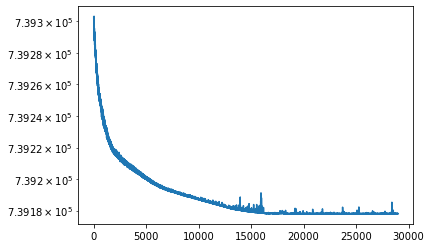

In [83]:
plt.plot(losses[1000:])
plt.yscale('log')
plt.show()

In [84]:
mus = mlp_VAE.encode(inputs)[1].reshape((-1, 3, 2)).detach()
stds = mlp_VAE.encode(inputs)[2].reshape((-1, 3, 2)).detach()

In [86]:
from matplotlib import patches

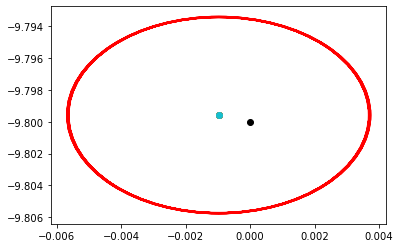

In [87]:
for i in range(len(mus)):
    plt.scatter(mus[i, 0, 0], mus[i, 0, 1])
    el = patches.Ellipse((mus[i, 0, 0], mus[i, 0, 1]), stds[i, 0, 0], stds[i,0,1], fc='None', ec='r')
    ax = plt.gca()
    ax.add_patch(el)

plt.scatter(a_target[:, 0], a_target[:, 1], c='k')
    
plt.show()

Note that, if we sample new trajectories, the predictions fall within the error range

In [88]:
new_target = trajectory_target + torch.normal(torch.zeros((1000,)+trajectory_target.shape), 
                                                torch.ones((1000,)+trajectory_target.shape)*0.2)

In [89]:
mus_new = mlp_VAE.encode(new_target)[1].reshape((-1, 3, 2)).detach()
stds_new = mlp_VAE.encode(new_target)[2].reshape((-1, 3, 2)).detach()

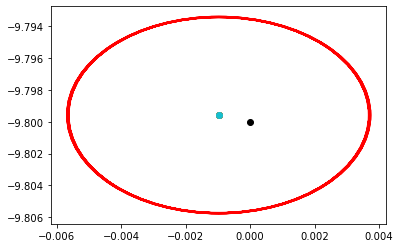

In [90]:
for i in range(len(mus_new)):
    plt.scatter(mus_new[i, 0, 0], mus_new[i, 0, 1])
    
    
for i in range(len(mus)):
    plt.scatter(mus[i, 0, 0], mus[i, 0, 1])
    el = patches.Ellipse((mus[i, 0, 0], mus[i, 0, 1]), stds[i, 0, 0], stds[i,0,1], fc='None', ec='r')
    ax = plt.gca()
    ax.add_patch(el)

plt.scatter(a_target[:, 0], a_target[:, 1], c='k')
    
plt.show()

In [96]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_other = torch.tensor([0, -12])[None, :]

#Initial velocity for fun (m / s)
v0_other = torch.tensor([5, 10])[None, :]

#Start at (0,10) [m]
x0_other = torch.tensor([0,10])[None, :]

#Data taken at 100 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[:, None]

trajectory_other = position(time_steps, a_other, x0_other, v0_other)

In [97]:
other_target = trajectory_other + torch.normal(torch.zeros((10,)+trajectory_other.shape), 
                                                torch.ones((10,)+trajectory_other.shape)*0.2)

In [98]:
mus_other = mlp_VAE.encode(other_target)[1].reshape((-1, 3, 2)).detach()
stds_other = mlp_VAE.encode(other_target)[2].reshape((-1, 3, 2)).detach()

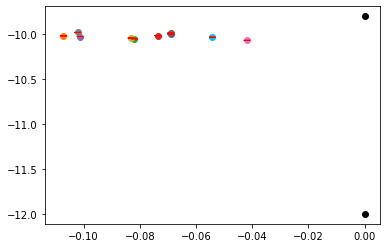

In [99]:
for i in range(len(mus_other)):
    plt.scatter(mus_other[i, 0, 0], mus_other[i, 0, 1])
    el = patches.Ellipse((mus_other[i, 0, 0], mus_other[i, 0, 1]), stds_other[i, 0, 0], stds_other[i,0,1], fc='None', ec='r')
    ax = plt.gca()
    ax.add_patch(el)

plt.scatter(a_target[:, 0], a_target[:, 1], c='k')
plt.scatter(a_other[:, 0], a_other[:, 1], c='k')
    
plt.show()